In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import qgrid
from clients.backtester import poloniex as px
from clients.backtester import helpers
from clients.backtester import gemini
from clients.pypoloniex.pypoloniex import LoadPairs, TimeSeries

## Data

In [31]:
def get_price_data_fpath(market, coin, exchange, period):
    fname = '{:s}_{:s}_{:s}_{:d}.csv'.format(
        exchange, market, coin, period)
    return os.path.join(cfg.DATA_DIR, fname)

def download_absolute_prices(market, coin, exchange, period, start, end):
    """
    market = base currency
    start = '4/2/2014'       # dd/mm/year
    end =  '11/2/2014'       # dd/mm/year
    period = 86400           # candle stick period in seconds
    """
    sess = TimeSeries()
    pair = (market, coin)
    sess.getData(pair, period, start, end)
    sess.toCSV(get_price_data_fpath(market, coin, exchange, period))
    return sess

def download_relative_prices(market, coin, exchange, period, days_back=30, days_data=30):
    """
    pair = "USDT_BTC"    # Use ETH pricing data on the BTC market
    period = 1800       # Use 1800 second candles
    daysBack = 30       # Grab data starting 30 days ago
    daysData = 30       # From there collect 60 days of data
    """
    pair = '{:s}_{:s}'.format(market, coin)
    data = px.getPast(pair, period, days_back, days_data)
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.index = df['date']
    df.drop('date', axis=1, inplace=True)

    fpath = get_price_data_fpath(market, coin, exchange, period)
    df.to_csv(fpath, index=True)
    sess = TimeSeries()
    sess.fromCSV(fpath)
    return sess

def load_historical_prices(market, coin, exchange, period):
    sess = TimeSeries()
    fpath = get_price_data_fpath(market, coin, exchange, period)
    sess.fromCSV(fpath)
    return sess

# def download_bulk_prices_ts(market, coins, exchange, period, start, end):
#     for coin in coins:
#         print("Downloading", coin)
#         ts = download_absolute_prices(market, coin, exchange, period, start, end)
#         print("Downloaded", coin, "Rows", len(ts.data))

## Cleaner

def download_prices(market, coin, exchange, period):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    ticker = '{:s}_{:s}'.format(market, coin)
    url = ('https://poloniex.com/public?command=returnChartData&currencyPair=' 
           + ticker + '&end=9999999999&period=' + str(period) + '&start=0')
    df = pd.read_json(url)
    df.set_index('date', inplace=True)
    fpath = get_price_data_fpath(market, coin, exchange, period)
    df.to_csv(fpath, index=True)
    print('Processed: ' + ticker, "Rows: ", len(df))
    return df    

def load_prices(market, coin, exchange, period):
    fpath = get_price_data_fpath(market, coin, exchange, period)
    df = pd.read_csv(fpath, index_col = 'date')
    df.dropna(inplace=True)
    df['date'] = [datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in df.index.values]
    df = df.set_index('date')
    return df

def download_bulk_prices(market, coins, exchange, period):
    for coin in coins:
        print("Downloading", coin)
        df = download_prices(market, coin, exchange, period)

def load_bulk_prices(market, coins, exchange, period):
    df = pd.DataFrame()
    for coin in coins:
        ticker = '{:s}_{:s}'.format(market, coin)
        df[ticker] = load_prices(market, coin, exchange, period)['close']
    df.dropna(inplace=True)
    return df

In [32]:
# Config
coin = c.ETH
market = c.BTC
exchange = c.POLONIEX
days_back = 30
days_data = 30
start_time = '1/1/2017'
end_time = '1/1/2018'
period = 1800

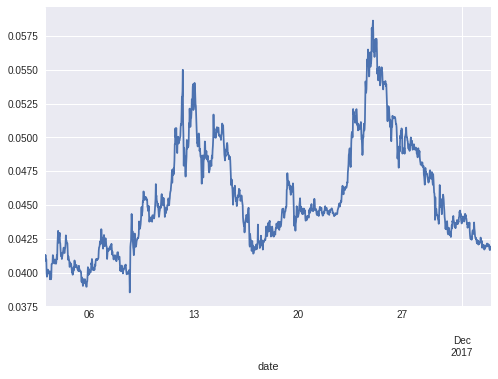

In [33]:
# Relative
relative = download_relative_prices(market, coin, exchange, period, 30, 30)
relative = load_historical_prices(market, coin, exchange, period)
relative.data['close'].plot()

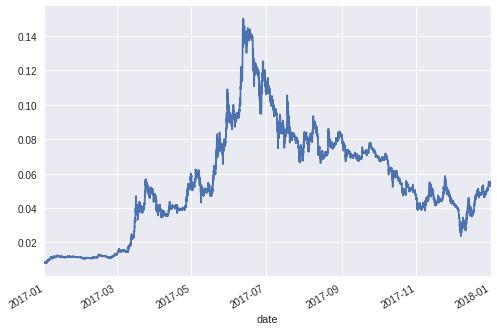

In [34]:
# Absolute
absolute = download_absolute_prices(market, coin, exchange, period, start_time, end_time)
absolute = load_historical_prices(market, coin, exchange, period)
absolute.data['close'].plot()

In [37]:
# Download Bulk All Available Data
coins = [c.LTC, c.ETH, c.XRP, c.XMR, c.DASH]
tickers =  ['USDT_ETC','USDT_XMR','USDT_ETH','USDT_DASH',
 'USDT_XRP','USDT_LTC','USDT_NXT','USDT_STR','USDT_REP','USDT_ZEC']
coins = [t.split('_')[-1] for t in tickers]
market = c.BTC
download_bulk_prices(market, coins, exchange, period)

Processed: BTC_ETC Rows:  25289
Processed: BTC_XMR Rows:  63542
Processed: BTC_ETH Rows:  42135
Processed: BTC_DASH Rows:  68360
Processed: BTC_XRP Rows:  59370
Processed: BTC_LTC Rows:  69353
Processed: BTC_NXT Rows:  69302
Processed: BTC_STR Rows:  59484
Processed: BTC_REP Rows:  21804
Processed: BTC_ZEC Rows:  20653


In [40]:
# Load Bulk Prices
bulk_prices = load_bulk_prices(market, coins, exchange, period)
bulk_prices.head()

,BTC_ETC,BTC_XMR,BTC_ETH,BTC_DASH,BTC_XRP,BTC_LTC,BTC_NXT,BTC_STR,BTC_REP,BTC_ZEC
date,,,,,,,,,,
2016-10-28 18:00:00,0.001390,0.008791,0.016070,0.013550,0.000012,0.005747,0.00001,0.000003,0.006852,490.0
2016-10-28 18:30:00,0.001380,0.008720,0.016155,0.013587,0.000012,0.005749,0.00001,0.000003,0.006851,1510.0
2016-10-28 19:00:00,0.001377,0.009000,0.016016,0.013600,0.000012,0.005744,0.00001,0.000003,0.006936,101.0
2016-10-28 19:30:00,0.001375,0.008841,0.015870,0.013510,0.000011,0.005722,0.00001,0.000003,0.006915,29.0
2016-10-28 20:00:00,0.001375,0.008417,0.016089,0.013470,0.000012,0.005739,0.00001,0.000003,0.006800,27.0


In [41]:
# Check for missing timesteps
def check_missing_timesteps(df, timestep):
    start_time = df.index[0]
    end_time = df.index[-1]
    print("Start", start_time)
    print("End", end_time)
    last_time = start_time
    n_missing = 0
    for idx,row in df[1:].iterrows():
        cur_time = idx
        if cur_time != last_time + datetime.timedelta(seconds=timestep):
            print("Expected:", last_time + datetime.timedelta(seconds=timestep), 
                  "| Time:", cur_time)
            n_missing += (cur_time - last_time).seconds//timestep
        last_time = cur_time
    return n_missing

In [42]:
#check_missing_timesteps(relative.data, period)
#check_missing_timesteps(absolute.data, period)
check_missing_timesteps(bulk_prices, period)

Start 2016-10-28 18:00:00
End 2018-01-02 00:00:00


0

## Explore

In [43]:
crypto_df = load_bulk_prices(market, coins, exchange, period)

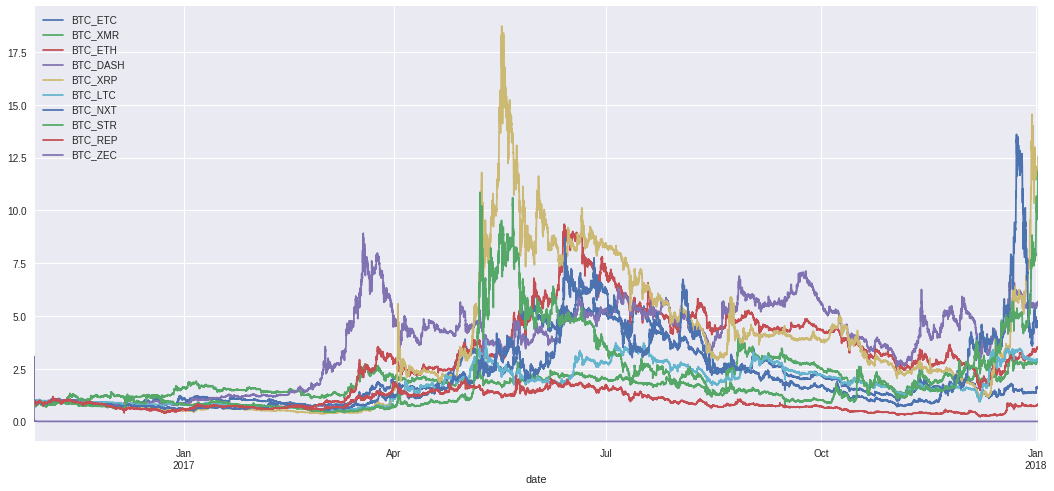

In [44]:
crypto_df_norm = crypto_df.divide(crypto_df.iloc[0])
crypto_df_pct = crypto_df.pct_change().dropna()
corr = crypto_df_pct.corr()
crypto_df_norm.plot(figsize=(18,8))

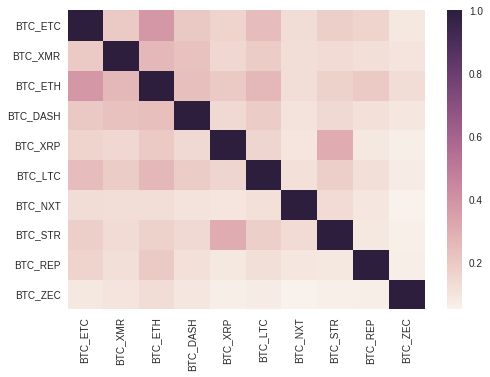

In [45]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

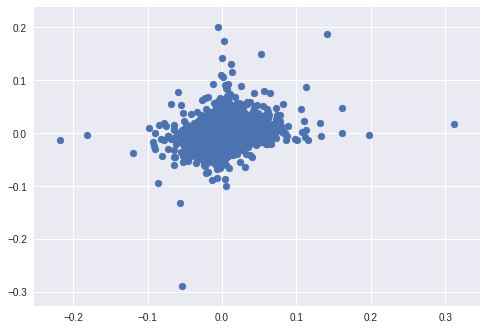

In [47]:
plt.scatter(crypto_df_pct[market+'_DASH'],crypto_df_pct[market+'_XMR'])

In [48]:
import statsmodels.api as sm
model = sm.OLS(crypto_df_pct[market+'_XMR'],
               crypto_df_pct[market+'_DASH']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BTC_XMR   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1105.
Date:                Mon, 01 Jan 2018   Prob (F-statistic):          3.61e-236
Time:                        16:32:46   Log-Likelihood:                 63708.
No. Observations:               20652   AIC:                        -1.274e+05
Df Residuals:                   20651   BIC:                        -1.274e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BTC_DASH       0.2126      0.006     33.248      0.000       0.200       0.225
==============================================================================
Omnibus:                     7532.509   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1460017.397
Skew:                           0.597   Prob(JB):                         0.00
Kurtosis:                      44.174   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

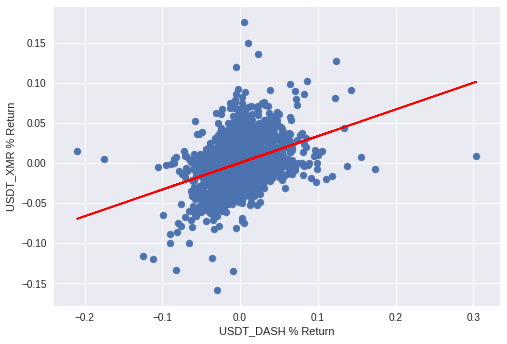

In [30]:
line=[model.params[0]*i for i in crypto_df_pct['USDT_DASH'].values]
plt.plot(crypto_df_pct['USDT_DASH'], line, c = 'r')
plt.scatter(crypto_df_pct['USDT_DASH'],crypto_df_pct['USDT_XMR'])
plt.xlabel('USDT_DASH % Return')
plt.ylabel('USDT_XMR % Return')

In [49]:
coin = c.LTC
market = c.BTC
exchange = c.POLONIEX
period = 300
df = download_prices(market, coin, exchange, period)

Processed: BTC_LTC Rows:  416114


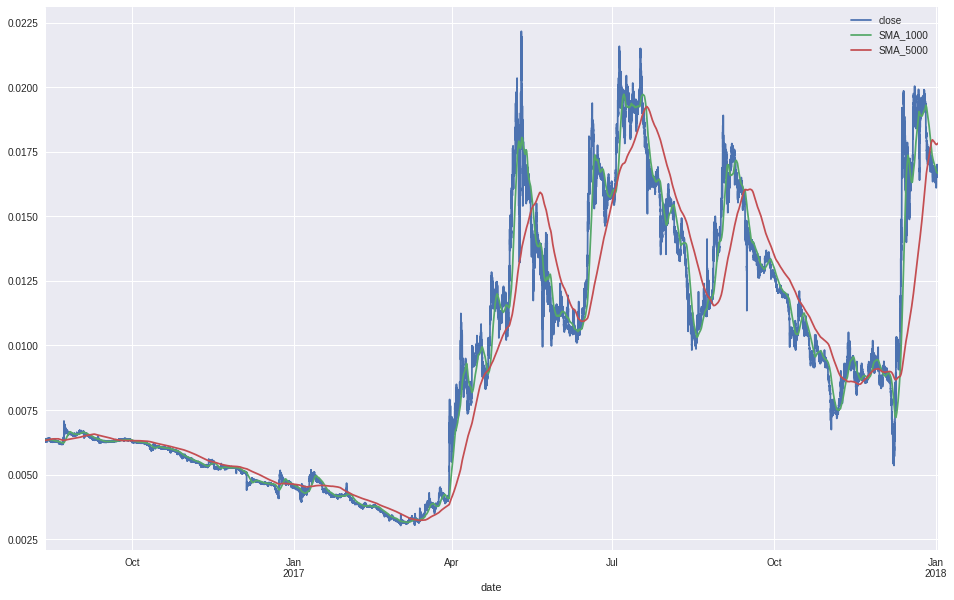

In [51]:
df[market+'_'+coin] = load_prices(market, coin, exchange, period)['close']
df['SMA_1000'] = df['close'].rolling(1000).mean()
df['SMA_5000'] = df['close'].rolling(5000).mean()
df[['close','SMA_1000','SMA_5000']][270000:].plot(figsize = (16,10))

In [52]:
def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

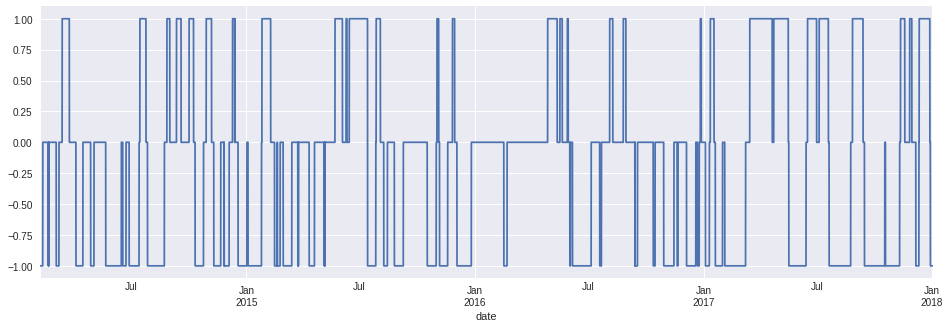

In [53]:
ma_df = test_ma(df, 1000, 5000).dropna()
ma_df['regime'].plot(figsize=(16,5))

In [54]:
ma_df[['Market','Strategy']].iloc[-1]

Market       0.666497
Strategy    13.268051
Name: 2018-01-02 00:30:00, dtype: float64

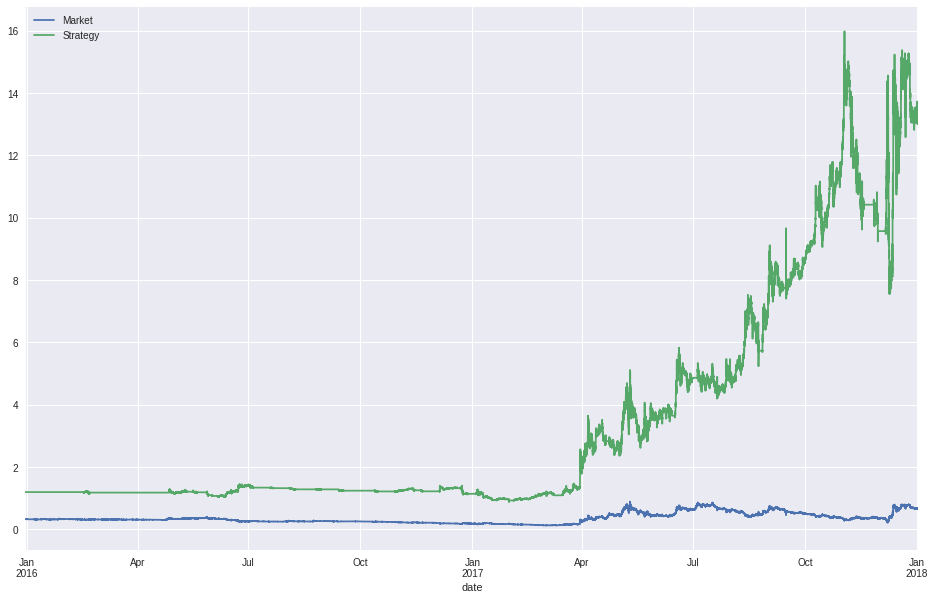

In [55]:
ma_df[['Market','Strategy']][200000:].plot(figsize = (16,10))

In [56]:
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)

In [ ]:
for lead, lag in lead_lags:
    pnls[lead][lag] = test_ma(df, lead, lag)['Strategy'][-1]
    #print(lead,lag,pnls[lead][lag])

In [ ]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs, cmap='PiYG')
#PNLs.max()

In [ ]:
df.dropna().head()

## API

* https://poloniex.com/support/api/
* https://pypi.python.org/pypi/poloniex
* https://github.com/Aula13/poloniex
* https://github.com/s4w3d0ff/python-poloniex
* https://pastebin.com/fbkheaRb